In [83]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


In [2]:
# import the data into dataframe
df_o = pd.read_csv("merge_data.csv", low_memory=False)

In [3]:
# make the copy of the dataframe
df = df_o.copy()

In [4]:
# checking the missing values 
df.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

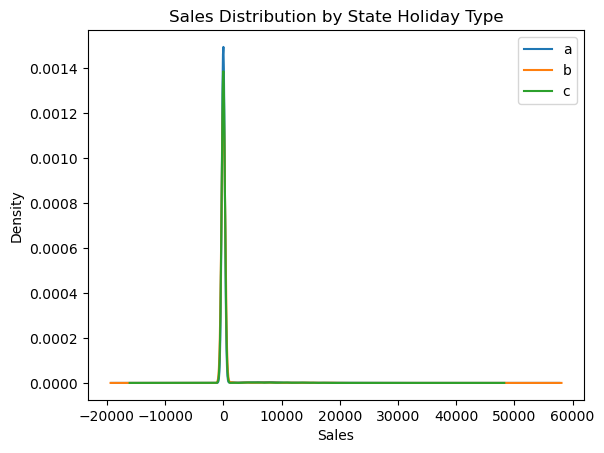

In [5]:
# Plotting the sales distribution for StateHoliday type "a", "b" 'c'.
df[df["StateHoliday"]=="a"]["Sales"].plot(kind="kde", label="a")
df[df["StateHoliday"]=="b"]["Sales"].plot(kind="kde", label="b")
df[df["StateHoliday"]=="c"]["Sales"].plot(kind="kde", label="c")
# Adding a legend to differentiate between the state holiday types.
plt.legend()
plt.title("Sales Distribution by State Holiday Type")
plt.xlabel("Sales")
plt.ylabel("Density")
plt.show()

The distributions of the sales for the different state holidays ('a', 'b', 'c') are indeed very similar, it may be wise to combine them into a single category for simplicity,

In [6]:
# combining the different kind of stateholiday 
df["StateHoliday"]=df["StateHoliday"].replace({"a":1, "b":1, 'c':1})
df["StateHoliday"]= df["StateHoliday"].astype(float)

In [7]:
# convert the date column to datetime and extract the hierarchy of date as column
df["Date"]=pd.to_datetime(df["Date"], infer_datetime_format=True)
df['MonthNumber'] = df['Date'].dt.strftime('%m').astype(int)
#df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Year'] = df['Date'].dt.year
# Extract Year, Month, and WeekOfYear from 'Date'
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

In [8]:
# set the date as index and drop the unnecessary column
df=df.set_index("Date").drop(columns=["Store", "Customers"])
# filter the df to include only where the "Open" column is 1.
df=df[df["Open"]==1]

# Creating function that will fit and evaluate different type of model

In [9]:
#Columns needed to compare metrics
comparison_columns = ['Model_Name', 'Train_MAE', 'Train_MSE', 'Train_RMSE', 'Train_R2' ,'Test_MAE', 'Test_MSE', 'Test_RMSE'
                    #  , 'Test_R2', 'Test_Adj_R2' , 'Train_Adj_R2'
                     ]




def model_and_evaluation(model_name, model_variable,X, k):
    X_train, X_test, y_train, y_test = train_test_split(X, k, test_size=0.3, random_state=42)
    
    
    scaler = StandardScaler() # Initialize the scaler
    scaler.fit(X_train)

    # Transform the training data
    X_train_scaled = scaler.transform(X_train)

    # Transform the test data
    X_test_scaled = scaler.transform(X_test)

    model = model_variable.fit(X_train_scaled,y_train)
    train_predict=model_variable.predict(X_train_scaled)
    test_predict=model_variable.predict(X_test_scaled)
    
       #calculate metrics and print the results for test set
    #Mean Absolute Error or MAE
    MAE_train = round(mean_absolute_error(y_train,train_predict),6)
    MAE_test = round(mean_absolute_error(y_test,test_predict),6)
    #Mean Squared Error or MSE
    MSE_train = round(mean_squared_error(y_train,train_predict),6)
    MSE_test = round(mean_squared_error(y_test,test_predict),6)
    #Root Mean Squared Error or RMSE
    RMSE_train = round(mean_squared_error(y_train,train_predict,squared=False),6)
    RMSE_test = round(mean_squared_error(y_test,test_predict,squared=False),6)
    #R2
    R2_train = round(r2_score(y_train, train_predict),6)
    R2_test = round(r2_score(y_test, test_predict),6)
    #Adjusted R2
   # Adj_r2_train = round(1 - (1-r2_score(y_train, y_pred_train)) * (len(y_train)-1)/(len(y_train)-x_train.shape[1]-1),6)
    #Adj_r2_test = round(1 - (1-r2_score(y_val, y_pred_test)) * (len(y_val)-1)/(len(y_val)-x_val.shape[1]-1),6)

    #printing test results
    print(f'The Mean Absolute Error for the validation set is {MAE_test}')
    print(f'The Mean Squared Error for the validation set is {MSE_test}')
    print(f'The Root Mean Squared Error for the validation set is {RMSE_test}')
    print(f'The R^2 for the validation set is {R2_test}')
  #  print(f'The Adjusted R^2 for the validation set is {Adj_r2_test}')


    plot_df=pd.DataFrame({ "Sales":y_test, "predicted sales":test_predict}, index=y_test.index,)
    # Aggregate data monthly to reduce noise
    plot_df = plot_df.resample('M').sum()

    # Plot the test results
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=plot_df)
    plt.ylabel("Total Sales and Predicted Sales")
    plt.xticks(rotation=45)
    plt.title(f'{model_name} - Sales vs Predicted Sales')
    plt.legend(labels=['Sales', 'Pred Sales'])
    plt.grid(axis="y")
    plt.show()  
    
    
    # Saving our results
    metric_scores = [model_name, MAE_train, MSE_train, RMSE_train, R2_train, MAE_test, MSE_test, RMSE_test,
                     #R2_test, Adj_r2_test, Adj_r2_train
                    ]
    final_dict = dict(zip(comparison_columns, metric_scores))
   # return [final_dict]

    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame([final_dict])
    return comparison_df

In [10]:
# split the df into features and target
X_1=df.copy()
y = X_1.pop("Sales")
# converting each category into a new binary column (dummy variable),
X_dummied=pd.get_dummies(X_1, columns=["StoreType", "Assortment", "PromoInterval"], drop_first=True)
X_dummied["WeekOfYear"]=X_dummied["WeekOfYear"].astype("float64")

# Model without Features Engineering or Features Selection

The Mean Absolute Error for the validation set is 849.703827
The Mean Squared Error for the validation set is 1792887.002603
The Root Mean Squared Error for the validation set is 1338.987305
The R^2 for the validation set is 0.813612


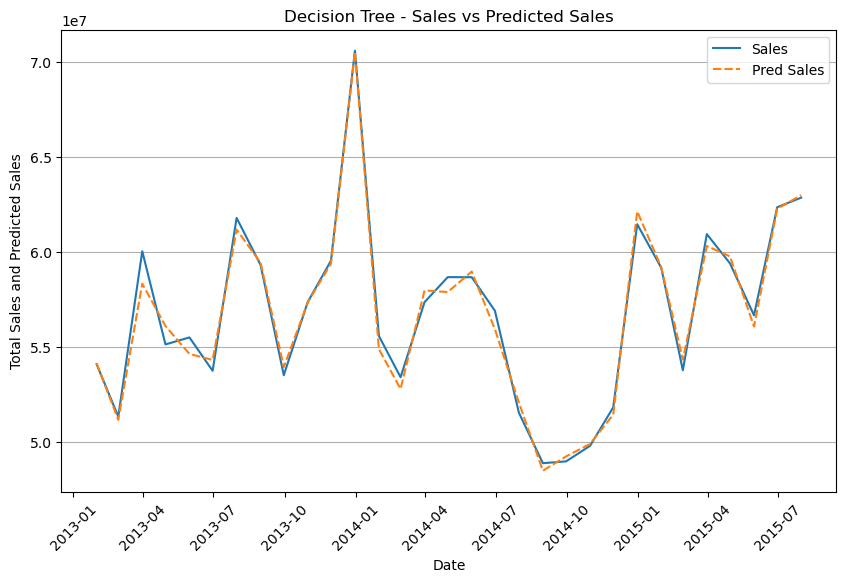

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Decision Tree,6.193732,13437.829642,115.921653,0.998607,849.703827,1.792887e+06,1338.987305


In [11]:
dt_basic = DecisionTreeRegressor(random_state=42) # Initialize the tree base model
model_and_evaluation("Decision Tree",dt_basic, X_dummied, y)

The Mean Absolute Error for the validation set is 650.304934
The Mean Squared Error for the validation set is 1022154.448195
The Root Mean Squared Error for the validation set is 1011.016542
The R^2 for the validation set is 0.893737


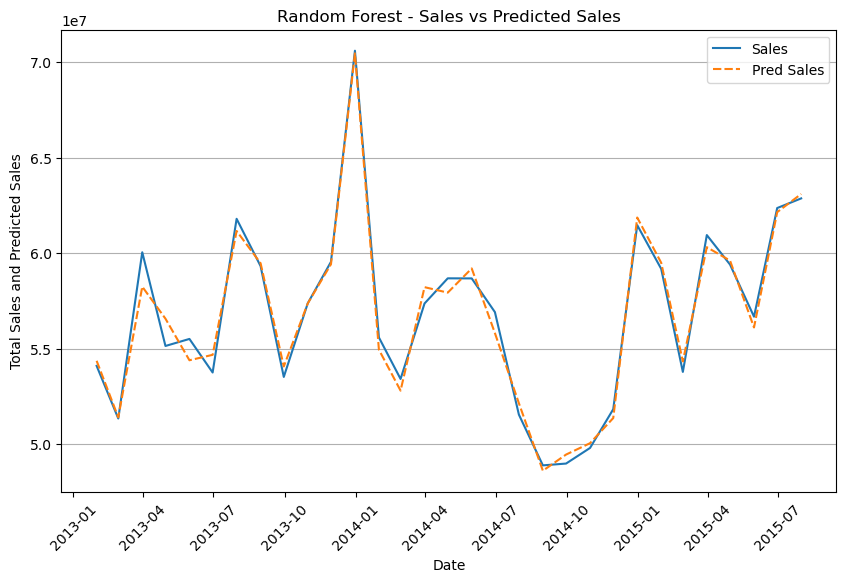

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Random Forest,244.611398,153076.463391,391.249873,0.984126,650.304934,1.022154e+06,1011.016542


In [12]:
rf_basic = RandomForestRegressor(random_state=42) # Initialize the random forest base model
model_and_evaluation("Random Forest",rf_basic, X_dummied, y)


### Recommendations:
1. **Random Forest over Decision Tree:** Based on the metrics, the Random Forest model outperforms the Decision Tree model. The Random Forest's ensemble technique helps mitigate overfitting and improves generalization, making it the better choice for this dataset.
  
2. **Feature Engineering & Selection:** Since neither feature engineering nor selection was applied, further improvement in model performance can be achieved by:
   - **Feature Engineering:** Create new features from existing ones to capture important patterns or interactions.
   - **Feature Selection:** Use methods like Recursive Feature Elimination (RFE) or Lasso Regression to select the most important features. This can improve model accuracy and reduce overfitting.
  
3. **Hyperparameter Tuning:** Perform hyperparameter optimization (e.g., using GridSearchCV or RandomizedSearchCV) for both models. Random Forest, in particular, can benefit significantly from fine-tuning parameters like the number of trees, maximum depth, and minimum samples split.

4. **Try Other Models:** Consider experimenting with other ensemble models like **Gradient Boosting Machines (GBM)** or **XGBoost**. These models often perform better in complex datasets and might provide further improvements.

# Model with Feature selection using RFE Technique 

In [13]:
# Initialize a Linear Regression model to be used as the estimator for feature selection.
model = LinearRegression()

# Apply Recursive Feature Elimination (RFE) to select the top 15 most important features.
# RFE works by recursively fitting the model and removing the least important feature until the desired number of features is reached.
recursion = RFE(estimator=model, n_features_to_select=15)

# Fit the RFE model on the dataset (X_dummied) with the target variable (y).
recursion.fit(X_dummied, y)

# Extract the names of the columns (features) that were selected by RFE.
columns = X_dummied.columns[recursion.support_]

# Create a new DataFrame (new_X) that contains only the selected features.
new_X = X_dummied[columns]

The Mean Absolute Error for the validation set is 1827.683109
The Mean Squared Error for the validation set is 6568356.252233
The Root Mean Squared Error for the validation set is 2562.88046
The R^2 for the validation set is 0.317157


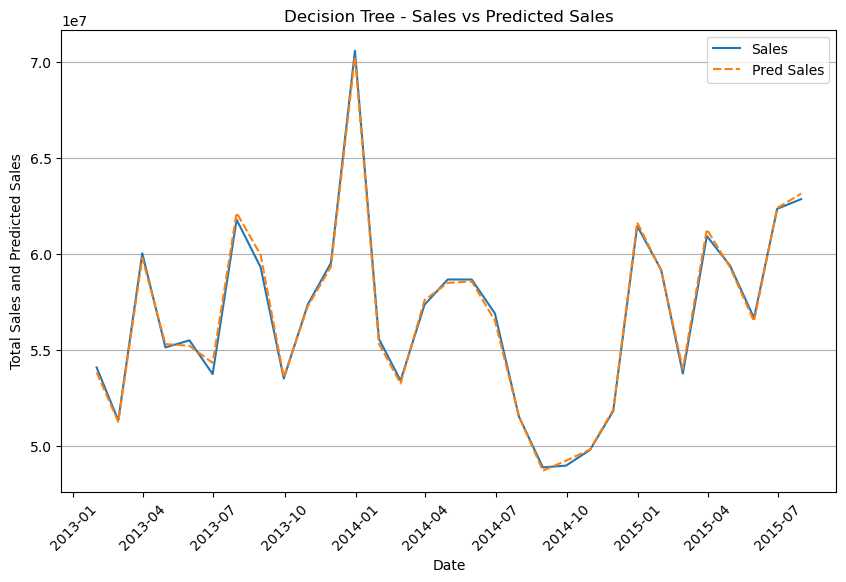

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Decision Tree,1689.591926,5.856016e+06,2419.920734,0.392744,1827.683109,6.568356e+06,2562.88046


In [14]:
model_and_evaluation("Decision Tree",dt_basic, new_X, y)

The Mean Absolute Error for the validation set is 1814.883486
The Mean Squared Error for the validation set is 6495010.666536
The Root Mean Squared Error for the validation set is 2548.53108
The R^2 for the validation set is 0.324782


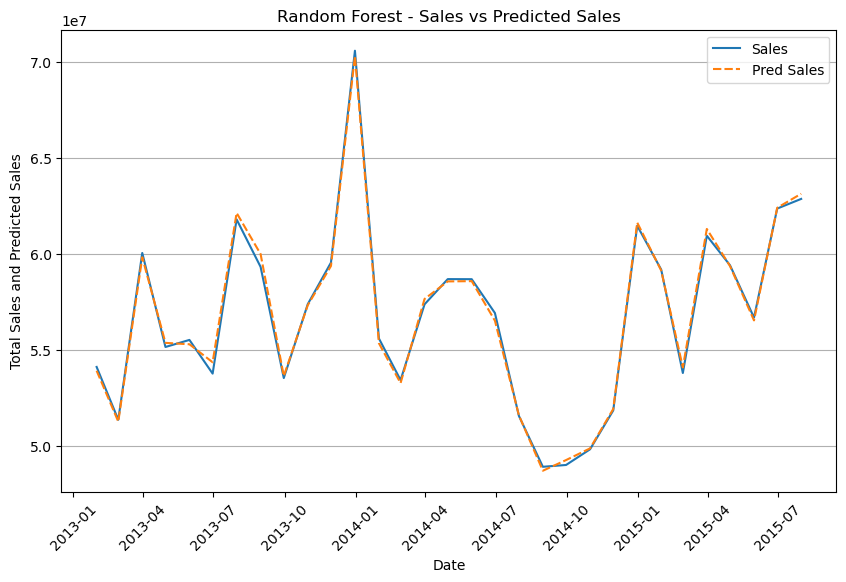

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Random Forest,1697.856003,5.866091e+06,2422.001382,0.391699,1814.883486,6.495011e+06,2548.53108


In [31]:
model_and_evaluation("Random Forest",rf_basic, new_X, y)


### What This Means:
- **Feature selection has harmed model performance.** By selecting only 15 features, important predictors might have been excluded, leading to a significant loss in predictive power. The model is now `underfitting`, meaning it does not capture enough complexity in the data.
  
- **RFE might have selected suboptimal features.** The selected features might not be the most relevant ones for predicting the target variable. In some cases, RFE might not work well without careful tuning or might discard critical features.

### Recommendations:
1. **Increase Number of Features Selected:** You may want to increase the number of features in RFE. The current selection of 15 features is likely too restrictive, so experimenting with a higher number (e.g., 20 or more) could improve results.
   
2. **Check Feature Importance:** Use models like Random Forests to check feature importance. This could help you determine which features contribute most to the model's accuracy, allowing you to adjust your feature selection approach.

3. **Review the Feature Selection Process:**
   - **Cross-Validation:** Ensure you are using cross-validation when performing RFE to better evaluate which features generalize well across different data splits.
   - **Use Other Feature Selection Techniques:** Try alternative feature selection methods, such as **Lasso** or **Embedded Methods** (like feature importance from tree-based models).

# Model with Feature selection using backward elimination Technique 

In [37]:
import statsmodels.api as sm
import pandas as pd

def backward_elimination(X, y, significance_level=0.05):
    # Add a constant term to the model (intercept)
    X = sm.add_constant(X)
    
    while True:
        model = sm.OLS(endog=y, exog=X).fit()  # Fit the model
        p_values = model.pvalues  # Extract p-values
        max_p_value = p_values.max()  # Find the max p-value
        
        if max_p_value > significance_level:  # If the max p-value is above the significance level
            excluded_variable = p_values.idxmax()  # Find the feature to exclude
            X = X.drop(columns=excluded_variable)  # Drop the feature
        else:
            break  # Stop if all p-values are below the threshold

    return model



In [63]:
final_model = backward_elimination(X_dummied,y)

# Print model summary
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                 1.387e+04
Date:                Sat, 07 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:06:49   Log-Likelihood:            -7.8835e+06
No. Observations:              844392   AIC:                         1.577e+07
Df Residuals:                  844374   BIC:                         1.577e+07
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
DayOfWeek   

In [ ]:
model_and_evaluation("Decision Tree",dt_basic, X_dummied[final_model.pvalues.index], y)

The Mean Absolute Error for the validation set is 891.393889
The Mean Squared Error for the validation set is 1848517.157433
The Root Mean Squared Error for the validation set is 1359.601838
The R^2 for the validation set is 0.807829


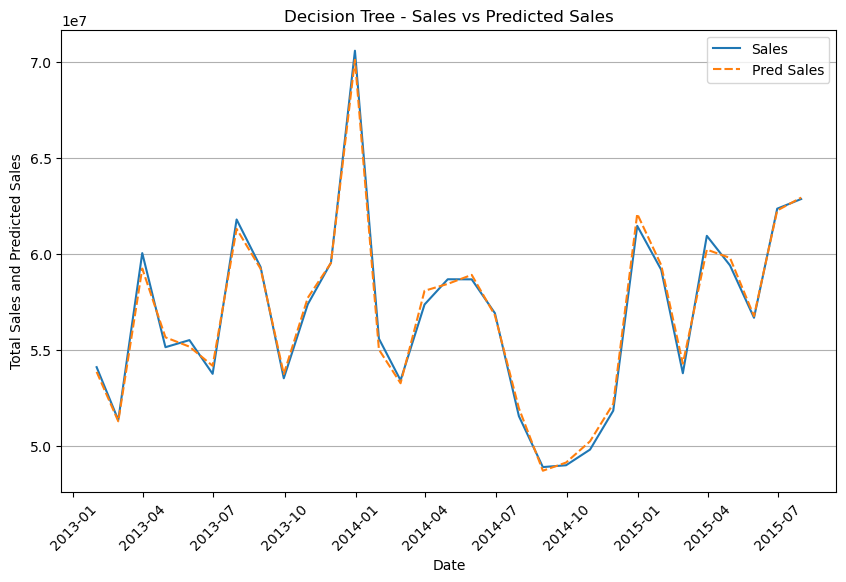

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Decision Tree,309.238711,363616.419043,603.006152,0.962294,891.393889,1.848517e+06,1359.601838



### What This Means:
- **Model Performance Decline:** The performance of the model after backward elimination has slightly decreased compared to the initial models that used all features without selection. Specifically, errors have increased (MAE, MSE, RMSE) and the R² score has dropped marginally.
  
- **Over-Simplification:** Backward elimination may have removed some important features, causing the model to become slightly underfitted. While backward elimination aims to simplify the model, it may not always yield the best predictive performance if key variables are removed.
  
- **Feature Selection Not Always Helpful:** In this case, feature selection via backward elimination didn’t improve the model’s performance. The increase in errors suggests that some excluded variables were important for the predictive power of the model.

### Recommendations:
1. **Increase Feature Set:** Consider retaining more features in the model by adjusting the **significance level** used in backward elimination (e.g., using a higher threshold like 0.1 instead of 0.05) to prevent over-simplification.
  
2. **Test Other Feature Selection Methods:** Try using other methods like **Lasso Regression** or **Random Forest Feature Importance** to select a better subset of features. This could help maintain accuracy while simplifying the model.

3. **Hyperparameter Tuning:** Fine-tuning the model’s hyperparameters might improve performance, even after feature selection.



# Feature Engineering 

In [69]:
df1 = df.copy()

In [70]:
#combining competition open since month and year into total months
df1['CompetitionOpen'] = (df1['Year'] - df1['CompetitionOpenSinceYear'])*12 + (df1['MonthNumber'] - df1['CompetitionOpenSinceMonth'])
#correcting the neg values
df1['CompetitionOpen'] = df1['CompetitionOpen'].apply(lambda x:0 if x < 0 else x)
#dropping both the columns
df1.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'], axis=1,inplace=True)

In [71]:
#changing promo2 features into meaningful inputs
#combining promo2 to total months

# Calculate Promo2Open
df1['Promo2Open'] = (df1['Year'] - df1['Promo2SinceYear']) * 12 + (df1['WeekOfYear'] - df1['Promo2SinceWeek']) * 0.230137

# Correct negative values
df1['Promo2Open'] = df1['Promo2Open'].apply(lambda x: 0 if x < 0 else x) * df1['Promo2']

# Create a function to check if Promo2 was running in the sale month
def promo2running(row):
    month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    try:
        months = row['PromoInterval'].split(',')
        if month_dict[row['MonthNumber']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

# Apply the function
df1['Promo2running'] = df1.apply(promo2running, axis=1) * df1['Promo2']

In [72]:
# Create a dictionary to map month numbers to their corresponding string values
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Define a function to check if the promotion is active for the given month
def is_promo_active(promo_interval, month_num):
    if pd.isna(promo_interval):
        return 0
    # Get the month string for the corresponding month number
    month_str = month_map[month_num]
    # Check if the month string is in the PromoInterval list
    return int(month_str in promo_interval.split(','))

# Apply the function vectorized using numpy's vectorize
df1['promo2active'] = np.vectorize(is_promo_active)(df1['PromoInterval'], df1['MonthNumber'])

In [73]:
# # Create a function to check if Promo2 was running in the sale month
# def promo2running(row):
#     month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
#     try:
#         months = row['PromoInterval'].split(',')
#         if month_dict[row['MonthNumber']] in months:
#             return 1
#         else:
#             return 0
#     except Exception:
#         return 0

# # Apply the function
# #df1['Promo2running'] = df1.apply(promo2running, axis=1) * df1['Promo2'

In [74]:
# Drop unnecessary columns
df1.drop(['Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval'], axis=1, inplace=True)

# Outliers Check using z_score Technique

In [75]:
# #code to seperate outliers
# # Calculate mean and standard deviation of Sales
# mean_sales = np.mean(df1['Sales'])
# sd_sales = np.std(df1['Sales'])

# # Define the threshold for identifying outliers
# threshold = 3

# # Identify outliers
# outliers = []
# for value in df1['Sales']:
#     z_score = (value - mean_sales) / sd_sales
#     if z_score > threshold:
#         outliers.append(value)

# # Total number of outliers
# print(f'Total number of Outliers present in the Sales column are {len(outliers)}.')

# # Plotting the outlier distribution
# plt.figure(figsize=(12, 8))
# sns.histplot(outliers, kde=True, color='teal', bins=30, edgecolor='black').set(title='Outliers Distribution')
# plt.xlabel('Sales Amount', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.title('Distribution of Sales Amount Outliers', fontsize=16)
# plt.grid(True)
# plt.show()

# Outliers Check using iqr Technique

In [76]:
# # Outlier removal

# result = df.select_dtypes(include='number')#selecting dtypes in dataset

# for i in result.columns:
#     percentile25 = df[i].quantile(0.25)
#     percentile75 = df[i].quantile(0.75)
    
#     iqr = percentile75-percentile25
    
#     upper_limit = percentile75 + 1.5 * iqr
#     lower_limit = percentile25 - 1.5 * iqr
    
#     df[df[i] > upper_limit]
#     df[df[i] < lower_limit]
    
#     df_new = df[df[i] < upper_limit ]
#     df_new = df[df[i] > lower_limit ]

Total number of Outliers present in the Sales column are 30769.


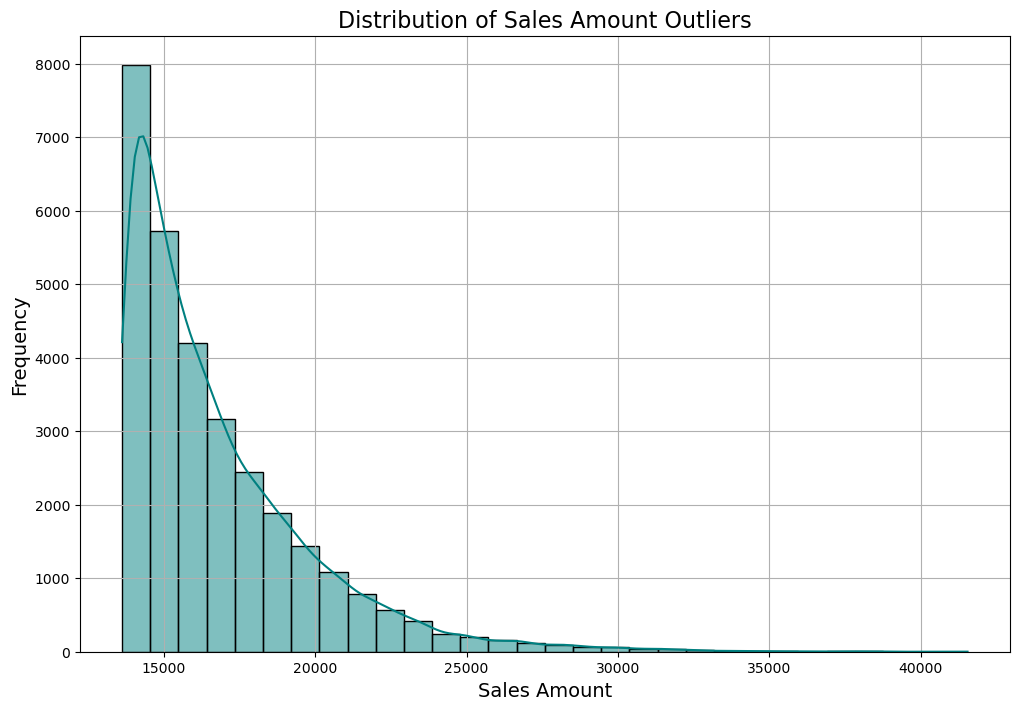

In [77]:
# Outlier removal

percentile25 = df1["Sales"].quantile(0.25)
percentile75 = df1["Sales"].quantile(0.75)

iqr = percentile75-percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

df_outliers=df1[(df1["Sales"] < lower_limit) | (df1["Sales"] > upper_limit)]
print(f'Total number of Outliers present in the Sales column are {len(df_outliers)}.')

# Plotting the outlier distribution
plt.figure(figsize=(12, 8))
sns.histplot(df_outliers["Sales"], kde=True, color='teal', bins=30, edgecolor='black').set(title='Outliers Distribution')
plt.xlabel('Sales Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Sales Amount Outliers', fontsize=16)
plt.grid(True)
plt.show()

### Summary of Outlier Analysis for Target Variable (Sales)

Upon performing an outlier analysis on the target variable `Sales`, several extreme values were identified. However, after careful examination, it was concluded that these outliers represent **true values** rather than data errors. These outliers likely reflect actual sales patterns, such as spikes due to promotions, seasonal demand, or other special events, as well as low sales during non-promotional periods.

Given that the outliers align with real-world business scenarios, they were retained in the dataset without further adjustments. The decision to keep these outliers ensures that the model captures the full range of sales behaviors, including unusual but valid variations.

In [78]:
categorical_cols=[  "Assortment", "StoreType"]
df1=pd.get_dummies(df1, columns=categorical_cols, drop_first=True)
X_ = df1.copy()
y_ = X_.pop("Sales")

The Mean Absolute Error for the validation set is 883.211898
The Mean Squared Error for the validation set is 2017197.415763
The Root Mean Squared Error for the validation set is 1420.280752
The R^2 for the validation set is 0.790293


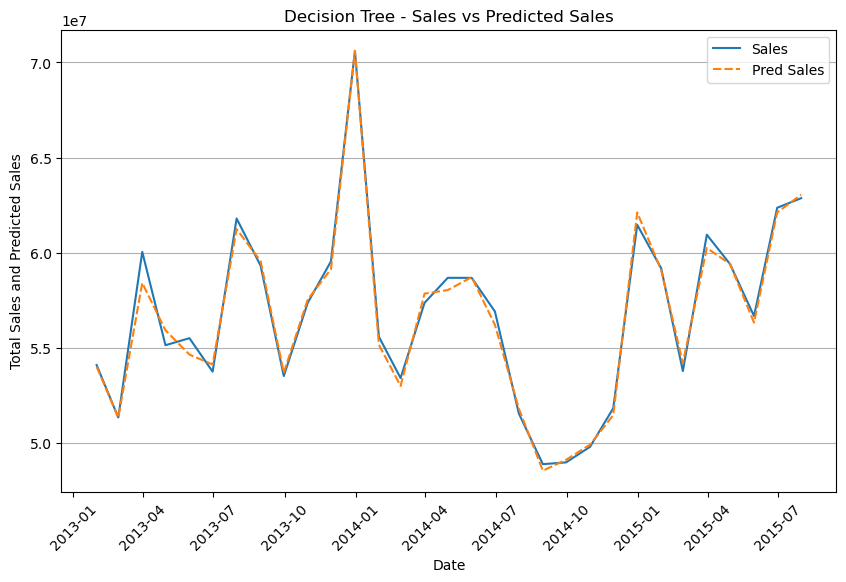

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Decision Tree,7.035799,15624.121699,124.996487,0.99838,883.211898,2.017197e+06,1420.280752


In [80]:
# train the new dataset with decision tree
model_and_evaluation("Decision Tree",dt_basic, X_, y_)

The Mean Absolute Error for the validation set is 682.596348
The Mean Squared Error for the validation set is 1145403.065273
The Root Mean Squared Error for the validation set is 1070.235051
The R^2 for the validation set is 0.880925


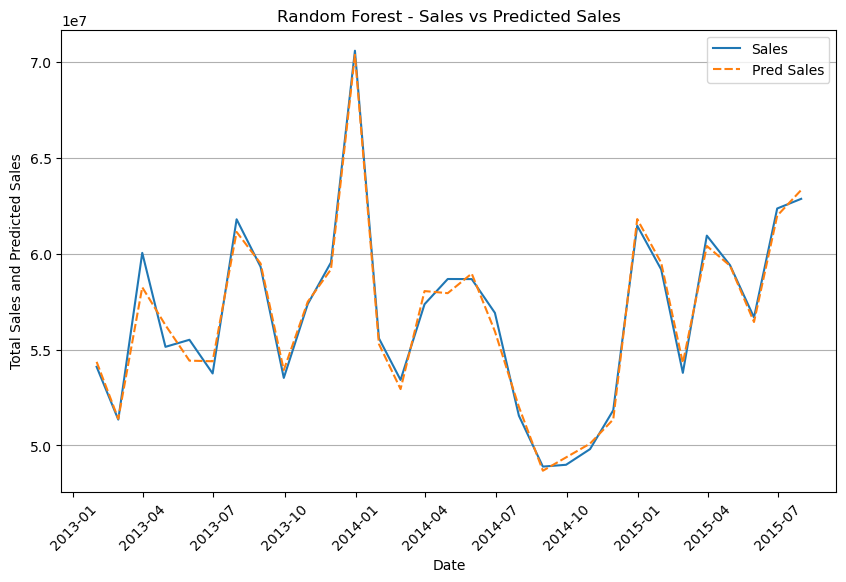

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Random Forest,256.818109,170910.405948,413.413118,0.982277,682.596348,1.145403e+06,1070.235051


In [82]:
# train the new dataset with random forest
model_and_evaluation("Random Forest",rf_basic, X_, y_)

### Summary of Model Development and Evaluation

1. **Initial Model Performance (Without Feature Engineering or Selection):**
   - Two models, **Decision Tree** and **Random Forest**, were trained without feature engineering or feature selection.
   - **Decision Tree**:
     - MAE: 849.70
     - MSE: 1,792,887.00
     - RMSE: 1,338.99
     - R²: 0.8136
   - **Random Forest**:
     - MAE: 650.30
     - MSE: 1,022,154.45
     - RMSE: 1,011.02
     - R²: 0.8937
   - **Conclusion:** Random Forest outperformed Decision Tree in every metric, making it a stronger candidate for further analysis.

2. **Feature Selection with Recursive Feature Elimination (RFE):**
   - After applying RFE to select 15 features, the model performance worsened:
     - MAE: 1,827.68
     - MSE: 6,568,356.25
     - RMSE: 2,562.88
     - R²: 0.3172
   - **Conclusion:** Feature selection resulted in underfitting, leading to increased errors and reduced R². It was concluded that RFE did not improve model performance and was not pursued further.

3. **Model Performance After Feature Engineering (Without Feature Selection):**
   - Feature engineering was applied, improving the feature set without performing selection.
   - **Decision Tree**:
     - MAE: 883.21
     - MSE: 2,017,197.42
     - RMSE: 1,420.28
     - R²: 0.7903
   - **Random Forest**:
     - MAE: 682.60
     - MSE: 1,145,403.07
     - RMSE: 1,070.24
     - R²: 0.8809
   - **Conclusion:** Once again, the **Random Forest** model significantly outperformed the Decision Tree. The errors were lower, and the R² score was higher, confirming that Random Forest was better suited for this problem.

4. **Outlier Analysis for Target (Sales):**
   - Outliers in the `Sales` target variable were analyzed and determined to be valid (reflecting real-world phenomena like promotions or seasonal demand).
   - **Conclusion:** The outliers were retained, as they represent true variations in sales behavior and should be considered during model training.

5. **Cross-Validation:**
   - Cross-validation will be applied to ensure robust model performance across different data splits. This step will further validate that the Random Forest model generalizes well to unseen data.

6. **Parameter Tuning:**
   - **Next Step:** Hyperparameter tuning for the Random Forest model will be conducted to further improve performance. Parameters like `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf` will be optimized to reduce errors and enhance predictive accuracy.

7. **Final Model Deployment:**
   - Once the Random Forest model is fine-tuned and validated through cross-validation, it will be deployed to make predictions on new data.
   - The deployment process will involve setting up a pipeline for predictions, monitoring model performance in a production environment, and updating the model periodically based on new data.

### Conclusion:
- The **Random Forest model** has consistently outperformed the Decision Tree model at every stage, showing superior accuracy and lower errors.
- **Hyperparameter tuning** will be conducted to refine the model's performance, after which the final model will be **deployed** for production use. 



# Hyperparameter Tuning for Random Forest
Hyperparameter tuning is essential for optimizing the performance of your Random Forest model.

In [84]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider for the best split
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the data
grid_search.fit(X_dummied,y)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

In [ ]:
import joblib

# Save the model to a file
joblib.dump(grid_search.best_estimator_, 'random_forest_model.pkl')

In [ ]:
# Load the model from a file
model = joblib.load('random_forest_model.pkl')

In [ ]:
# Load the model from the file
model = joblib.load('random_forest_model.pkl')

# Define a function to make predictions
def make_prediction(features):
    prediction = model.predict([features])
    return prediction[0]

In [ ]:
# Example usage
sample_features = [value1, value2, value3, ...]  # Replace with actual feature values
prediction = make_prediction(sample_features)
print("Prediction:", prediction)
